In [ ]:
# SMS Spam Detection Model
# Phase 1: Model Development and Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import joblib
import pickle
import os
import time
from google.colab import drive
from google.colab import files

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set up directories for saving model artifacts
MODEL_DIR = '/content/spam_detection_model/'
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
DATASET_PATH = '/content/spam.csv'

In [ ]:
def load_data(file_path, encoding='cp1252'):
    """
    Load data from CSV file
    """
    # utf8 default encoding
    print(f"Loading data from {file_path}")
    try:
        df = pd.read_csv(file_path, encoding=encoding)
        print(f"Data loaded successfully with shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data with {encoding} encoding: {str(e)}")
        try:
            # use latin! for faiover encoding
            alt_encoding = 'utf-8' if encoding != 'utf-8' else 'latin1'
            df = pd.read_csv(file_path, encoding=alt_encoding)
            print(f"Data loaded with {alt_encoding} encoding. Shape: {df.shape}")
            return df
        except Exception as e2:
            print(f"Failed to load data with alternative encoding: {str(e2)}")
            raise


In [ ]:
def explore_data(df):
    """
    Generate basic statistics and visualizations about the data before cleaning
    """
    print("Exploring data...")

    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    display(df.head())

    print("\nColumn information:")
    display(df.info())

    print("\nMissing values count:")
    display(df.isnull().sum())

    # Basic statistics
    stats = {
        'shape': df.shape,
        'columns': list(df.columns),
        'missing_values': df.isnull().sum().to_dict(),
        'data_types': df.dtypes.astype(str).to_dict()
    }

    # If we have 'label' or 'v1' column for spam/ham classification, add distribution
    label_col = 'label' if 'label' in df.columns else 'v1' if 'v1' in df.columns else None
    if label_col:
        print("\nClass distribution:")
        class_dist = df[label_col].value_counts()
        print(class_dist)
        stats['class_distribution'] = class_dist.to_dict()

        # Visualize the class distribution
        plt.figure(figsize=(8, 6))
        sns.countplot(x=label_col, data=df)
        plt.title('Distribution of Spam vs. Ham Messages')
        plt.xlabel('Message Type')
        plt.ylabel('Count')
        plt.show()

    # If we have message text column, explore text length
    text_col = 'message' if 'message' in df.columns else 'v2' if 'v2' in df.columns else None
    if text_col:
        # Add text length as a feature
        df['text_length'] = df[text_col].apply(len)

        print("\nText length statistics:")
        display(df['text_length'].describe())

        # Visualize message length distribution by class
        if label_col:
            plt.figure(figsize=(12, 6))
            sns.histplot(data=df, x='text_length', hue=label_col, bins=50, kde=True)
            plt.title('Message Length Distribution by Class')
            plt.xlabel('Message Length (characters)')
            plt.ylabel('Frequency')
            plt.xlim(0, 500)  # Focus on the most common lengths
            plt.show()

    return stats

In [ ]:
def clean_text(text):
    """
    Clean and normalize text data

    """
    # lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
def preprocess_data(df, label_col='v1', text_col='v2'):
    """
    Clean and preprocess the data
    """
    print("Starting data preprocessing...")

    processed_df = df.copy()

    # Rename columns if using default names
    if label_col != 'label' or text_col != 'message':
        column_mapping = {label_col: 'label', text_col: 'message'}
        processed_df = processed_df.rename(columns=column_mapping)
        print(f"Renamed columns: {column_mapping}")

    # Drop unnecessary columns (if they exist)
    cols_to_drop = [col for col in processed_df.columns if col.startswith('Unnamed:')]
    if cols_to_drop:
        processed_df = processed_df.drop(columns=cols_to_drop)
        print(f"Dropped unnecessary columns: {cols_to_drop}")

    # Check for and handle missing values
    missing_values = processed_df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Found missing values: {missing_values}")
        processed_df = processed_df.dropna()
        print(f"Dropped rows with missing values. New shape: {processed_df.shape}")

    # Encode labels
    label_encoder = LabelEncoder()
    processed_df['label_encoded'] = label_encoder.fit_transform(processed_df['label'])
    print(f"Encoded labels: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

    #  text length as a feature
    processed_df['text_length'] = processed_df['message'].apply(len)

    # Clean messages
    print("Cleaning text messages...")
    processed_df['clean_message'] = processed_df['message'].apply(clean_text)

    # Display example of original and cleaned messages
    print("\n\nExample of original vs. cleaned messages:")
    for i in range(3):
        print(f"Original: {processed_df['message'].iloc[i]}")
        print(f"Cleaned: {processed_df['clean_message'].iloc[i]}")
        print()

    print("Data preprocessing completed")
    return processed_df, label_encoder


In [ ]:
def create_features(df, vectorizer_type='tfidf', max_features=5000, test_size=0.2, random_state=42):
    """
    Create features and split into training/testing sets
    """
    print(f"\n\nStarting feature engineering with {vectorizer_type} vectorizer...")

    # Split the data
    X = df['clean_message']
    y = df['label_encoded']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples)")

    # Initialize vectorizer
    if vectorizer_type.lower() == 'count':
        vectorizer = CountVectorizer(max_features=max_features)
        print(f"Using CountVectorizer with max_features={max_features}")
    else:
        vectorizer = TfidfVectorizer(max_features=max_features)
        print(f"Using TfidfVectorizer with max_features={max_features}")

    # Fit and transform the training data
    X_train_features = vectorizer.fit_transform(X_train)
    X_test_features = vectorizer.transform(X_test)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"Number of features: {len(feature_names)}")
    print("Sample features (words):", feature_names[:10])

    print(f"Feature extraction completed. Train features shape: {X_train_features.shape}")

    return X_train_features, X_test_features, y_train, y_test, vectorizer


In [ ]:
def train_model(X_train, y_train, model_type='naive_bayes'):
    """
    Train a specific machine learning model
    naive bayes by default cuz it's the best for the job now
    """
    models = {
        'naive_bayes': MultinomialNB(),
        'logistic': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
        'svm': SVC(kernel='linear', random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Available types: {list(models.keys())}")

    print(f"Training {model_type} model...")
    start_time = time.time()

    model = models[model_type]
    model.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Model training completed in {training_time:.2f} seconds")

    return model

In [ ]:
def train_all_models(X_train, y_train, X_test, y_test):
    """
    Train all available models and select the best one
    """
    print("Training all models for comparison...")

    models = {
        'naive_bayes': MultinomialNB(),
        'logistic': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
        'svm': SVC(kernel='linear', random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        start_time = time.time()

        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Evaluate on test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'model': model,
            'accuracy': float(accuracy),
            'training_time': training_time
        }

        print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    # Select the best model
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model = results[best_model_name]['model']

    print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

    return results, best_model_name, best_model


In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate the model performance
    """
    print("\nEvaluating model performance...")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = float(accuracy_score(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    class_report_dict = classification_report(y_test, y_pred, output_dict=True)

    print(f"Model accuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    display(pd.DataFrame(
        conf_matrix,
        index=[f'Actual {c}' for c in label_encoder.classes_],
        columns=[f'Predicted {c}' for c in label_encoder.classes_]
    ))

    print("\nClassification Report:")
    print(class_report)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report_dict
    }

In [ ]:
def save_model(model, vectorizer, label_encoder, output_dir=MODEL_DIR, model_name='spam_detection_model'):
    """
    Save the model and related components

    Args:
        model: Trained model
        vectorizer: Fitted vectorizer
        label_encoder: Fitted label encoder
        output_dir (str): Directory to save the model
        model_name (str): Base name for the model files

    Returns:
        dict: Paths where artifacts were saved
    """
    os.makedirs(output_dir, exist_ok=True)

    model_path = os.path.join(output_dir, f"{model_name}.pkl")
    vectorizer_path = os.path.join(output_dir, f"{model_name}_vectorizer.pkl")
    label_encoder_path = os.path.join(output_dir, f"{model_name}_label_encoder.pkl")

    print(f"Saving model to {model_path}")
    joblib.dump(model, model_path)

    print(f"Saving vectorizer to {vectorizer_path}")
    joblib.dump(vectorizer, vectorizer_path)

    print(f"Saving label encoder to {label_encoder_path}")
    joblib.dump(label_encoder, label_encoder_path)

    # Save metadata
    metadata = {
        'model_creation_time': time.strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': type(model).__name__,
        'vectorizer_type': type(vectorizer).__name__,
        'files': {
            'model': model_path,
            'vectorizer': vectorizer_path,
            'label_encoder': label_encoder_path
        }
    }

    metadata_path = os.path.join(output_dir, f"{model_name}_metadata.json")
    with open(metadata_path, 'w') as f:
        import json
        json.dump(metadata, f, indent=2)

    print(f"Model metadata saved to {metadata_path}")

    saved_paths = {
        'model': model_path,
        'vectorizer': vectorizer_path,
        'label_encoder': label_encoder_path,
        'metadata': metadata_path
    }

    return saved_paths



In [ ]:
def load_model(model_dir=MODEL_DIR, model_name='spam_detection_model'):
    """
    Load a previously saved model and related components for predictions
    """
    model_path = os.path.join(model_dir, f"{model_name}.pkl")
    vectorizer_path = os.path.join(model_dir, f"{model_name}_vectorizer.pkl")
    label_encoder_path = os.path.join(model_dir, f"{model_name}_label_encoder.pkl")

    print(f"Loading model from {model_path}")
    model = joblib.load(model_path)

    print(f"Loading vectorizer from {vectorizer_path}")
    vectorizer = joblib.load(vectorizer_path)

    print(f"Loading label encoder from {label_encoder_path}")
    label_encoder = joblib.load(label_encoder_path)

    return model, vectorizer, label_encoder


In [ ]:

def predict_spam(message, model, vectorizer, label_encoder):
    """
    Predict whether a message is spam or ham
    """
    # Handle single string input
    if isinstance(message, str):
        message = [message]

    # Clean the text
    cleaned_texts = [clean_text(msg) for msg in message]

    # Vectorize
    features = vectorizer.transform(cleaned_texts)

    # Predict
    predictions = model.predict(features)

    # Get probabilities if model supports it
    probabilities = None
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features)

    # Convert numeric predictions back to labels
    predicted_labels = label_encoder.inverse_transform(predictions)

    # Prepare results
    results = []
    for i, (msg, label) in enumerate(zip(message, predicted_labels)):
        result = {
            'message': msg,
            'prediction': label
        }

        # Add probability if available
        if probabilities is not None:
            # Find the index of the predicted class
            class_idx = list(label_encoder.classes_).index(label)
            result['probability'] = float(probabilities[i][class_idx])

        results.append(result)

    return results

Model Testing and script running

In [ ]:
def run_full_pipeline(data_path, train_all_models_flag=False, vectorizer_type='tfidf', model_type='naive_bayes'):
  # execution time start
  start_time = time.time()


  df = load_data(data_path)

  # STEP 2: DATA EXPLORATION
  stats = explore_data(df)

  # STEP 3: DATA PREPROCESSING
  processed_df, label_encoder = preprocess_data(df)

  # STEP 4: FEATURE ENGINEERING
  # Try both TF-IDF and Count Vectorizers
  X_train_tfidf, X_test_tfidf, y_train, y_test, tfidf_vectorizer = create_features(
    processed_df, vectorizer_type=vectorizer_type
  )

  # STEP 5: MODEL TRAINING
  # Compare different models
  print("\n== TRAINING MULTIPLE MODELS FOR COMPARISON ==")
  if train_all_models_flag:
    model_results, best_model_name, best_model = train_all_models(
    X_train_tfidf, y_train, X_test_tfidf, y_test)
  else:
    best_model = train_model(X_train_tfidf, y_train, model_type=model_type)
    best_model_name = model_type
    model_results = {model_type: {'model': best_model}}



  # STEP 6: MODEL EVALUATION
  evaluation_metrics = evaluate_model(best_model, X_test_tfidf, y_test, label_encoder)

  # STEP 7: MODEL SAVING
  saved_paths = save_model(best_model, tfidf_vectorizer, label_encoder)

  # STEP 8: MODEL TESTING
  test_messages = [
    "Congratulations! You've won a $1000 gift card. Call now to claim your prize!",
    "Hey, can we meet for coffee tomorrow at 3pm?",
    "URGENT: Your bank account has been suspended. Click here to verify your information.",
    "I'll be home late tonight. Don't wait up.",
    "FREE entry into our prize draw! Just reply with your credit card details to enter!",
    "Meeting canceled for today. Will reschedule for next week.",
    "We've sent some money into your bank account and it needs urgent attendtion. Do this and gain a bonous"
  ]

  print("\n== TESTING MODEL WITH SAMPLE MESSAGES ==")
  predictions = predict_spam(test_messages, best_model, tfidf_vectorizer, label_encoder)
  for i, pred in enumerate(predictions):
    print(f"Message {i+1}: {pred['message']}")
    print(f"Prediction: {pred['prediction']}")
    if 'probability' in pred:
        print(f"Confidence: {pred['probability']:.2f}")
    print()

    # execution time
  execution_time = time.time() - start_time

  return {
      'best_model': best_model_name,
      'accuracy': evaluation_metrics['accuracy'],
      'execution_time': execution_time,
      'saved_paths': saved_paths
  }





== RUNNING COMPLETE AUTOMATED PIPELINE ==
Loading data from /content/spam.csv
Data loaded successfully with shape: (5572, 5)
Exploring data...
Dataset shape: (5572, 5)

First few rows:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


None


Missing values count:


,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566



Class distribution:
v1
ham     4825
spam     747
Name: count, dtype: int64


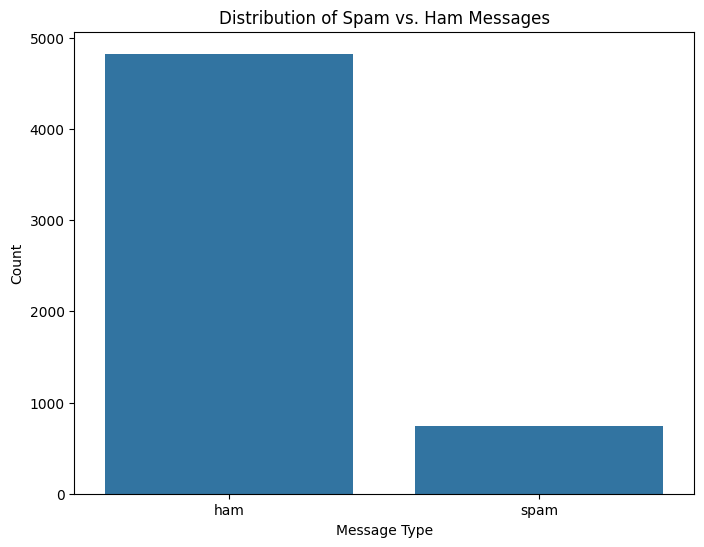


Text length statistics:


,text_length
count,5572.000000
mean,80.118808
std,59.690841
min,2.000000
25%,36.000000
50%,61.000000
75%,121.000000
max,910.000000


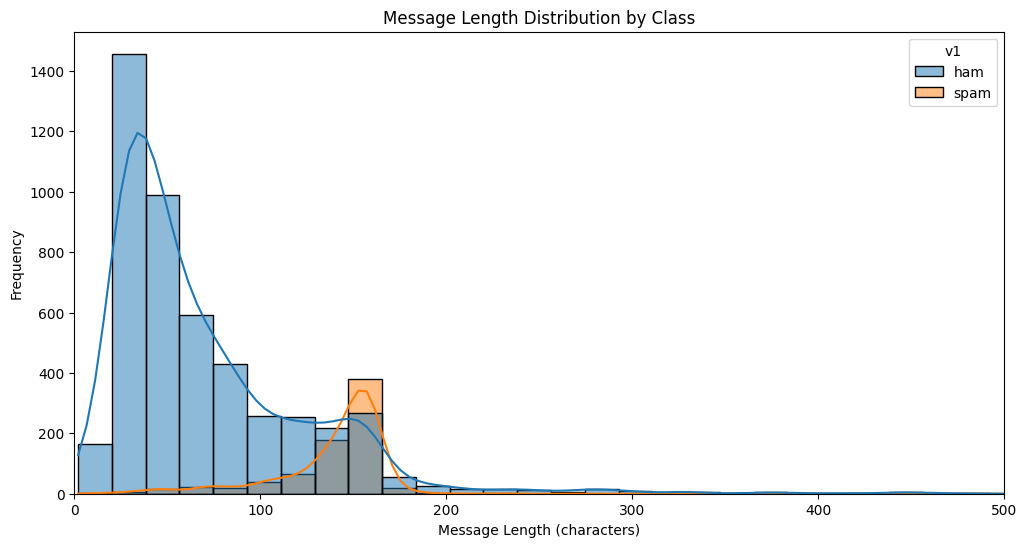

Starting data preprocessing...
Renamed columns: {'v1': 'label', 'v2': 'message'}
Dropped unnecessary columns: ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Encoded labels: {'ham': np.int64(0), 'spam': np.int64(1)}
Cleaning text messages...

Example of original vs. cleaned messages:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat

Original: Ok lar... Joking wif u oni...
Cleaned: ok lar joking wif u oni

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Cleaned: free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs

Data preprocessing completed
Starting feature engineering with tfidf vectorizer...
Data split into training (4457

,Predicted ham,Predicted spam
Actual ham,965,1
Actual spam,16,133



Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



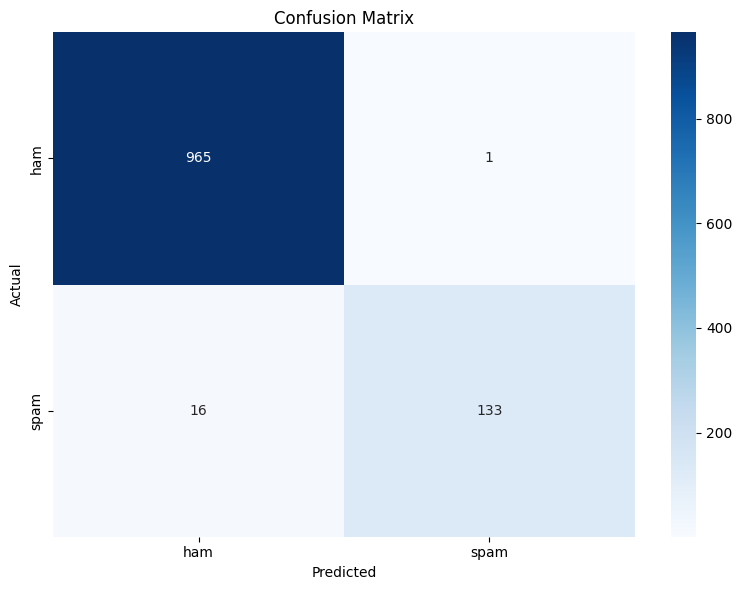

Saving model to /content/spam_detection_model/spam_detection_model.pkl
Saving vectorizer to /content/spam_detection_model/spam_detection_model_vectorizer.pkl
Saving label encoder to /content/spam_detection_model/spam_detection_model_label_encoder.pkl
Model metadata saved to /content/spam_detection_model/spam_detection_model_metadata.json

== TESTING MODEL WITH SAMPLE MESSAGES ==
Message 1: Congratulations! You've won a $1000 gift card. Call now to claim your prize!
Prediction: spam

Message 2: Hey, can we meet for coffee tomorrow at 3pm?
Prediction: ham

Message 3: URGENT: Your bank account has been suspended. Click here to verify your information.
Prediction: spam

Message 4: I'll be home late tonight. Don't wait up.
Prediction: ham

Message 5: FREE entry into our prize draw! Just reply with your credit card details to enter!
Prediction: spam

Message 6: Meeting canceled for today. Will reschedule for next week.
Prediction: ham

Message 7: We've sent some money into your bank account 

In [ ]:
# AUTOMATE THE ENTIRE PIPELINE
print("\n== RUNNING COMPLETE AUTOMATED PIPELINE ==")
# This will run all the steps above in a single function call
# Assign the result to a different variable name to avoid overwriting the function name
pipeline_results_final = run_full_pipeline(
    data_path='/content/spam.csv',  # Change to your file path
    train_all_models_flag=True,
    vectorizer_type='tfidf'
)

print("\n== PIPELINE RESULTS SUMMARY ==")
print(f"Best model: {pipeline_results_final['best_model']}") # Use the new variable here
print(f"Accuracy: {pipeline_results_final['accuracy']:.4f}") # Use the new variable here
print(f"Execution time: {pipeline_results_final['execution_time']:.2f} seconds")
print(f"Model saved to: {pipeline_results_final['saved_paths']['model']}") # Use the new variable here

# Final message
print("\nSMS Spam Detection Pipeline completed successfully!")
print("The model is now ready for deployment.")